# Welcome to CS 5242 **Homework 7**

ASSIGNMENT DEADLINE ⏰ : **6 Nov 2022, 23:59**

In this assignment, we have three questions. This is the second question and please write the answer in this notebook.

Colab is a hosted Jupyter notebook service that requires no setup to use, while providing access free of charge to computing resources including GPUs. In this semester, we will use Colab to run our experiments.

### **Grades Policy**

We have 10 points for this homework. 15% off per day late, 0 scores if you submit it 7 days after the deadline.

### **Cautions**

**DO NOT** copy the code from the internet, e.g. GitHub.

**DO NOT** use external libraries like Tensorflow, keras in your implementation.

---

### **Contact**

Please feel free to contact us if you have any question about this homework or need any further information.

Slack (Recommend): Lin Qiuxia

TA Email: qiuxia.lin@u.nus.edu

> If you have not join the slack group, you can click [here](https://join.slack.com/t/cs5242ay20222-oiw1784/shared_invite/zt-1eiv24k1t-0J9EI7vz3uQmAHa68qU0aw)

# Question 2 (3 Points)
In this Question, we'll leverage the U-Net architecture to predict the class that corresponds to all the pixels in the image. 

Most codes are provided and a few codes are missing. Please enter your codes in the highlighted parts and run all the cells to provide proper outputs. 

Feel free to adjust model hyperparameter values when training the model. 

In [32]:
import os
if not os.path.exists('dataset1'):
    !wget -q https://www.dropbox.com/s/0pigmmmynbf9xwq/dataset1.zip
    !unzip -q dataset1.zip
    !rm dataset1.zip
    !pip install -q torch_snippets pytorch_model_summary

from torch_snippets import *
from torchvision import transforms
from sklearn.model_selection import train_test_split
import numpy as np
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [33]:
tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet
])

In [34]:
from torch.utils.data import DataLoader, Dataset
class SegData(Dataset):
    def __init__(self, split):
        self.items = stems(f'dataset1/images_prepped_{split}')
        self.split = split
    def __len__(self):
        return len(self.items)
    def __getitem__(self, ix):
        image = read(f'dataset1/images_prepped_{self.split}/{self.items[ix]}.png', 1)
        image = cv2.resize(image, (224,224))
        mask = read(f'dataset1/annotations_prepped_{self.split}/{self.items[ix]}.png')
        mask = cv2.resize(mask, (224,224))
        return image, mask
    def choose(self): return self[randint(len(self))]
    def collate_fn(self, batch):
        ims, masks = list(zip(*batch))
        ims = torch.cat([tfms(im.copy()/255.)[None] for im in ims]).float().to(device)
        ce_masks = torch.cat([torch.Tensor(mask[None]) for mask in masks]).long().to(device)
        return ims, ce_masks

In [35]:
trn_ds = SegData('train')
val_ds = SegData('test')
trn_dl = DataLoader(trn_ds, batch_size=4, shuffle=True, collate_fn=trn_ds.collate_fn)
val_dl = DataLoader(val_ds, batch_size=1, shuffle=True, collate_fn=val_ds.collate_fn)

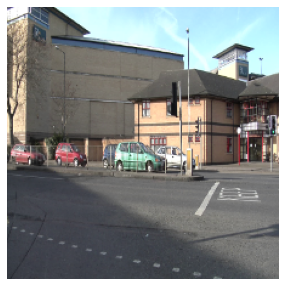

In [36]:
show(trn_ds[10][0])

In [37]:
trn_ds[10][0].shape

(224, 224, 3)

In [78]:
class DownSamplingLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownSamplingLayer, self).__init__()
        self.conv_bn_relu = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=(3,3), stride=(1,1), padding='same'),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=(3,3), stride=(1,1), padding='same'),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
        self.down_sampling_layer = nn.Sequential(
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=(3,3), stride=(2,2), padding=(1,1)),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        out = self.conv_bn_relu(x)
        out = self.down_sampling_layer(out)
        return out

class UpSamplingLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpSamplingLayer, self).__init__()
        self.out_channels = out_channels
        self.conv_bn_relu = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels * 2, kernel_size=(3,3), stride=(1,1), padding='same'),
            nn.BatchNorm2d(out_channels * 2),
            nn.ReLU(),
            nn.Conv2d(in_channels=out_channels * 2, out_channels=out_channels * 2, kernel_size=(3,3), stride=(1,1), padding='same'),
            nn.BatchNorm2d(out_channels * 2),
            nn.ReLU()
        )

        self.up_sampling_layer = nn.ConvTranspose2d(in_channels=out_channels * 2, out_channels=out_channels, kernel_size=(3,3), stride=(2,2), padding=(1,1))
        self.output_layer = nn.Sequential(
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        x_out = self.conv_bn_relu(x)
        B, _, H, W = x_out.shape
        x_out = self.up_sampling_layer(x_out, [B, self.out_channels, H*2 , W*2])
        x_out = self.output_layer(x_out)
        return x_out

class UNet(nn.Module):
    def __init__(self, pretrained=True, out_channels=12):
        super(UNet, self).__init__()
        ###################################
        ###Please enter your codes here####
        ###################################
        self.input_channel = 3
        self.channels = [64, 128, 256, 512, 1024]

        self.down_sampling_layers = nn.ModuleList(
            [DownSamplingLayer(in_channels=self.input_channel, out_channels=self.channels[0])]
        )
        for i in range(1, len(self.channels)):
            d = DownSamplingLayer(in_channels=self.channels[i-1], out_channels=self.channels[i])
            self.down_sampling_layers.append(d)

        self.up_sampling_layers = nn.ModuleList(
            [UpSamplingLayer(in_channels=self.channels[-1], out_channels=self.channels[-2])]
        )
        for i in range(len(self.channels) - 2, 0, -1):
            u = UpSamplingLayer(in_channels=self.channels[i] * 2, out_channels=self.channels[i-1])
            self.up_sampling_layers.append(u)
        self.up_sampling_layers.append(UpSamplingLayer(in_channels=self.channels[0] * 2, out_channels=self.channels[0]))

        self.output_layer = nn.Sequential(
            nn.Conv2d(in_channels=self.channels[0], out_channels=out_channels, kernel_size=(3,3), stride=(1,1), padding='same'),
            nn.Sigmoid()
        )
        ####################################

    def forward(self, x):
        ###################################
        ###Please enter your codes here####
        ###################################
        out = x
        down_sampling_res = []
        for i in range(len(self.down_sampling_layers)):
            out = self.down_sampling_layers[i](out)
            down_sampling_res.append(out)

        out = self.up_sampling_layers[0](out)
        for i in range(1, len(self.up_sampling_layers)):
            idx = len(self.down_sampling_layers) - 1 - i
            out = self.up_sampling_layers[i](torch.cat((out, down_sampling_res[idx]), dim=1))
        out = self.output_layer(out)
        return out
        ####################################

In [79]:
ce = nn.CrossEntropyLoss()
def UnetLoss(preds, targets):
    ce_loss = ce(preds, targets)
    acc = (torch.max(preds, 1)[1] == targets).float().mean()
    return ce_loss, acc

In [80]:
def train_batch(model, data, optimizer, criterion):
    model.train()
    ims, ce_masks = data
    _masks = model(ims)
    optimizer.zero_grad()
    loss, acc = criterion(_masks, ce_masks)
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
    model.eval()
    ims, masks = data
    _masks = model(ims)
    loss, acc = criterion(_masks, masks)
    return loss.item(), acc.item()

In [91]:
from torch.optim.lr_scheduler import ExponentialLR
model = UNet().to(device)
criterion = UnetLoss
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = ExponentialLR(optimizer, gamma=0.9, verbose=True)
n_epochs = 30

Adjusting learning rate of group 0 to 1.0000e-03.


In [92]:
log = Report(n_epochs)
for ex in range(n_epochs):
    N = len(trn_dl)
    for bx, data in enumerate(trn_dl):
        loss, acc = train_batch(model, data, optimizer, criterion)
        log.record(ex+(bx+1)/N, trn_loss=loss, trn_acc=acc, end='\r')

    N = len(val_dl)
    for bx, data in enumerate(val_dl):
        loss, acc = validate_batch(model, data, criterion)
        log.record(ex+(bx+1)/N, val_loss=loss, val_acc=acc, end='\r')
    print()
    scheduler.step()
        
print("train_acc:", [v for pos, v in log.trn_acc][-1], "|val_acc:", [v for pos, v in log.val_acc][-1])

EPOCH: 1.000  val_loss: 1.909  val_acc: 0.592  (22.69s - 657.97s remaining)

Adjusting learning rate of group 0 to 9.0000e-04.
EPOCH: 2.000  val_loss: 1.823  val_acc: 0.623  (45.80s - 641.27s remaining)

Adjusting learning rate of group 0 to 8.1000e-04.
EPOCH: 3.000  val_loss: 1.820  val_acc: 0.614  (68.85s - 619.66s remaining)

Adjusting learning rate of group 0 to 7.2900e-04.
EPOCH: 4.000  val_loss: 1.808  val_acc: 0.628  (92.04s - 598.27s remaining)

Adjusting learning rate of group 0 to 6.5610e-04.
EPOCH: 5.000  val_loss: 1.800  val_acc: 0.664  (115.55s - 577.73s remaining)

Adjusting learning rate of group 0 to 5.9049e-04.
EPOCH: 6.000  val_loss: 1.799  val_acc: 0.731  (139.07s - 556.27s remaining)

Adjusting learning rate of group 0 to 5.3144e-04.
EPOCH: 7.000  val_loss: 1.801  val_acc: 0.638  (162.69s - 534.57s remaining)

Adjusting learning rate of group 0 to 4.7830e-04.
EPOCH: 8.000  val_loss: 1.817  val_acc: 0.749  (186.84s - 513.81s remaining)

Adjusting learning rate of group 0 to 4.3047e-04.
EPOCH: 9.000  val_loss: 1.765  val_acc: 0.834  (210.65s - 491.51s remaining)

Adjusting learning rate of group 0 to 3.8742e-04.
EPOCH: 10.000  val_loss: 1.757  val_acc: 0.817  (234.68s - 469.35s remaining)

Adjusting learning rate of group 0 to 3.4868e-04.
EPOCH: 11.000  val_loss: 1.765  val_acc: 0.843  (258.57s - 446.63s remaining)

Adjusting learning rate of group 0 to 3.1381e-04.
EPOCH: 12.000  val_loss: 1.699  val_acc: 0.924  (282.53s - 423.80s remaining)

Adjusting learning rate of group 0 to 2.8243e-04.
EPOCH: 13.000  val_loss: 1.757  val_acc: 0.862  (306.67s - 401.03s remaining)

Adjusting learning rate of group 0 to 2.5419e-04.
EPOCH: 14.000  val_loss: 1.703  val_acc: 0.922  (330.72s - 377.96s remaining)

Adjusting learning rate of group 0 to 2.2877e-04.
EPOCH: 15.000  val_loss: 1.754  val_acc: 0.852  (354.78s - 354.78s remaining)

Adjusting learning rate of group 0 to 2.0589e-04.
EPOCH: 16.000  val_loss: 1.787  val_acc: 0.826  (379.12s - 331.73s remaining)

Adjusting learning rate of group 0 to 1.8530e-04.
EPOCH: 17.000  val_loss: 1.732  val_acc: 0.886  (403.33s - 308.43s remaining)

Adjusting learning rate of group 0 to 1.6677e-04.
EPOCH: 18.000  val_loss: 1.697  val_acc: 0.924  (427.69s - 285.13s remaining)

Adjusting learning rate of group 0 to 1.5009e-04.
EPOCH: 19.000  val_loss: 1.730  val_acc: 0.877  (452.06s - 261.72s remaining)

Adjusting learning rate of group 0 to 1.3509e-04.
EPOCH: 20.000  val_loss: 1.790  val_acc: 0.828  (476.19s - 238.10s remaining)

Adjusting learning rate of group 0 to 1.2158e-04.
EPOCH: 21.000  val_loss: 1.746  val_acc: 0.863  (500.57s - 214.53s remaining)

Adjusting learning rate of group 0 to 1.0942e-04.
EPOCH: 22.000  val_loss: 1.725  val_acc: 0.886  (524.74s - 190.81s remaining)

Adjusting learning rate of group 0 to 9.8477e-05.
EPOCH: 23.000  val_loss: 1.764  val_acc: 0.849  (548.96s - 167.08s remaining)

Adjusting learning rate of group 0 to 8.8629e-05.
EPOCH: 24.000  val_loss: 1.726  val_acc: 0.878  (573.35s - 143.34s remaining)

Adjusting learning rate of group 0 to 7.9766e-05.
EPOCH: 25.000  val_loss: 1.785  val_acc: 0.833  (597.66s - 119.53s remaining)

Adjusting learning rate of group 0 to 7.1790e-05.
EPOCH: 26.000  val_loss: 1.738  val_acc: 0.870  (621.97s - 95.69s remaining)

Adjusting learning rate of group 0 to 6.4611e-05.
EPOCH: 27.000  val_loss: 1.751  val_acc: 0.853  (646.43s - 71.83s remaining)

Adjusting learning rate of group 0 to 5.8150e-05.
EPOCH: 28.000  val_loss: 1.742  val_acc: 0.872  (670.76s - 47.91s remaining)

Adjusting learning rate of group 0 to 5.2335e-05.
EPOCH: 29.000  val_loss: 1.701  val_acc: 0.910  (695.21s - 23.97s remaining)

Adjusting learning rate of group 0 to 4.7101e-05.
EPOCH: 30.000  val_loss: 1.731  val_acc: 0.886  (719.74s - 0.00s remaining)

Adjusting learning rate of group 0 to 4.2391e-05.


train_acc: 0.8967633843421936 |val_acc: 0.8863002061843872

100%|██████████| 131/131 [00:00<00:00, 716.85it/s]


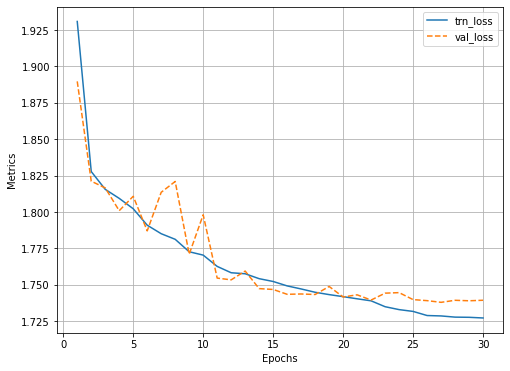

In [93]:
log.plot_epochs(['trn_loss','val_loss'])

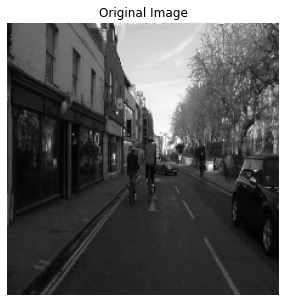

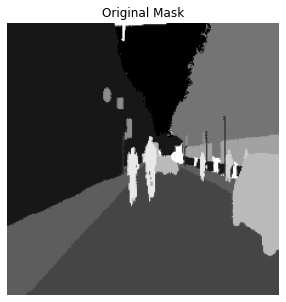

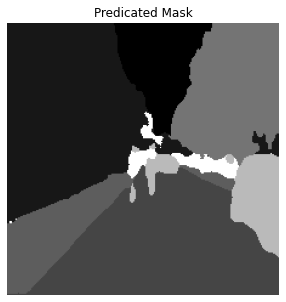

In [94]:
ims, masks = next(iter(val_dl))
output = model(ims)
_, _masks = torch.max(output, 1)
show(ims[0].permute(1,2,0).detach().cpu()[:,:,0], title ="Original Image")
show(masks.permute(1,2,0).detach().cpu()[:,:,0], title ="Original Mask")
show(_masks.permute(1,2,0).detach().cpu()[:,:,0], title ="Predicated Mask")